# Data mapping - Extras

This notebook contains additional materials related to Lab 3. These are not compulsory but rather suggested in case you have extra time and/or interest.

In [11]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

For this tutorial, we will use the recently released 2015 Index of Multiple Deprivation (IMD) for England and Wales. This dataset can be most easily downloaded from the CDRC data store ([link](https://data.cdrc.ac.uk/dataset/cdrc-english-indices-of-deprivation-2015-geodata-pack-liverpool-e08000012)) and, since it already comes both in tabular as well as spatial data format (shapefile), it does not need merging or joining to additional geometries.

Although all the elements of the IMD, including the ranks and the scores themselves, are in the IMD dataset, we will also be combining them with additional data from the Census, to explore how deprivation is related to other socio-demographic characteristics of the area. For that we will revisit the Census Data Pack ([link](https://data.cdrc.ac.uk/dataset/cdrc-2011-census-data-packs-for-local-authority-district-liverpool-e08000012)) we used previously.

In order to create maps with a base layer that provides context, we will be using a raster file derived from [OS VectorMap District (Backdrop Raster)](https://www.ordnancesurvey.co.uk/business-and-government/products/vectormap-district.html) and available for download on [this link](http://darribas.org/gds15/content/labs/figs/lab04_liverpool.tif).

As usual, let us set the paths to the folders containing the files before anything so we can then focus on data analysis exclusively (keep in mind the specific paths will probably be different for your computer):

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = '../data/E08000012/shapefiles/E08000012.shp'
liv_path = '../data/lab04_liverpool.tif'
data_path = '../data/Liverpool/'

**IMPORTANT**: the paths above might have look different in your computer. See [this introductory notebook](begin.html) for more details about how to set your paths.

* **IMD data**

Now we can load up the IMD data exactly as we did earlier for a shapefile:

In [3]:
# Read the file in
imd = gpd.read_file(imd_shp)
# Index it on the LSOA ID
imd = imd.set_index('LSOA11CD')
# Display summary
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   imd_rank    298 non-null    int64   
 1   imd_score   298 non-null    float64 
 2   income      298 non-null    float64 
 3   employment  298 non-null    float64 
 4   education   298 non-null    float64 
 5   health      298 non-null    float64 
 6   crime       298 non-null    float64 
 7   housing     298 non-null    float64 
 8   living_env  298 non-null    float64 
 9   idaci       298 non-null    float64 
 10  idaopi      298 non-null    float64 
 11  geometry    298 non-null    geometry
dtypes: float64(10), geometry(1), int64(1)
memory usage: 40.3+ KB


Note how on line 4 we *index* the resulting table `imd` with the column `LSOA11CD`. Effectively, this means we are "naming" the rows, the same way we the columns are named, using the column `LSOA11CD`, which contains the unique ID's of each area. This affords us some nice slicing and querying capabilities as well as permitting to merge the table with other ones more easily. 

Pay attention also to how exactly we index the table: we create a new object that is named in the same way, `imd`, but that contains the result of applying the function `set_index` to the original object `imd`. As usual, there are many ways to index a table in Python, but this is one of the most direct and expressive ones.

* **Census data**

In order to explore additional dimensions of deprivation, and to have categorical data to display with "unique values" choropleths, we will use some of the Census data pack. Although most of the Census variables are continuous, we will transform them to create *categorical* characteristics. Remember a categorical variable is one that comprises only a limited number of potential values, and these are not comparable with each other across a numerical scale. For example, religion or country of origin are categorical variables. It is not possible to compare their different values in a quantitative way (religion A is not double or half of religion B) but instead they represent qualitative differences.

In particular, we are going to use tables `QS104EW` (Gender) and `KS103EW` (marital status). The way these are presented in its raw form is as tabulated counts of each of the possible categories. Our strategy to turn these into a single categorical variable for each case is to compare the counts for each area and assign that of the largest case. For example, in the first case, an area will be labelled as "male" if there are more males than females living in that particular LSOA. In the case of marital status, although there are more cases, we will simplify and use only "married" and "single" and assign one or the other on the bases of which ones are more common in each particular area.

**NOTE**: the following code snippet involves some data transformations that are a bit more advanced that what is covered in this course. Simply run them to load the data, but you are not expected to know some of the coding tricks required in this cell.

In [4]:
                # Gender breakup
# Read table (csv file)
gender = pd.read_csv(data_path+'tables/QS104EW_lsoa11.csv', index_col='GeographyCode')
# Rename columns from code to human-readable name
gender = gender.rename(columns={'QS104EW0002': 'Male', \
                                'QS104EW0003': 'Female'})[['Male', 'Female']]
# Create male-female switcher
maj_male = gender['Male'] > gender['Female']
# Add "Gender_Majority" variable to table and assign the switcher
gender['Gender_Majority'] = maj_male
# Replace `True` values with "Male" and `False` with "Female"
gender.loc[gender['Gender_Majority']==True, 'Gender_Majority'] = 'Male'
gender.loc[gender['Gender_Majority']==False, 'Gender_Majority'] = 'Female'

                # Status breakup
# Read table (csv file)
sinmar = pd.read_csv(data_path+'tables/KS103EW_lsoa11.csv', index_col='GeographyCode')
# Rename columns from code to human-readable name
sinmar = sinmar.rename(columns={'KS103EW0002': 'Single', \
                                'KS103EW0003': 'Married'})[['Single', 'Married']]
# Create sigle-married switcher
maj_sin = sinmar['Single'] > sinmar['Married']
# Add "Status_Majority" variable to table and assign the switcher
sinmar['Status_Majority'] = maj_sin
# Replace `True` values with "Single" and `False` with "Married"
sinmar.loc[sinmar['Status_Majority']==True, 'Status_Majority'] = 'Single'
sinmar.loc[sinmar['Status_Majority']==False, 'Status_Majority'] = 'Married'

# Join
both = imd.join(sinmar).join(gender)
# Reset the CRS after join
both.crs = imd.crs

## `[Extension 1]` Cartograms

Cartograms are maps that represent the spatial distribution of a variable not by encoding it in a color palette by rather by modifying geographical objects. There are many algorithms to distort the shapes of geographical entities according to values, some of them incredibly complicated and complex. 

As an example of how to create a relatively straight-forward cartogram, we will convert polygons into points by using their centroids, and will define the size of the dot proportionally to the value of the variable we want to display, the IMD score in this case. We will adopt a different approach to plot points than we have done so far. This involves first extracting the coordinates of the points:

In [8]:
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])

**NOTE**: The line of code above contains some elements that reflect more advanced Python programming that we have covered so far, so you should feel free to simply run it to extract the points.

---

If you are interested in the logic however, it uses a technique called "list comprehension", which can compress and entire `for` loop into a single line of code, producing more elegant and, to the trained eye, more readable code. Essentially, the line above can be unpacked into the following loop:

In [6]:
pts = []
for pt in imd.centroid:
    pts.append((pt.x, pt.y))
pts = np.array(pts)

---

Once we have extracted them, we can display them through the command `plt.scatter`. This is equivalent to the straightforward `plot`, or to loop over each point, with the difference that it will allow us to modify the size of the dots according to a variable:

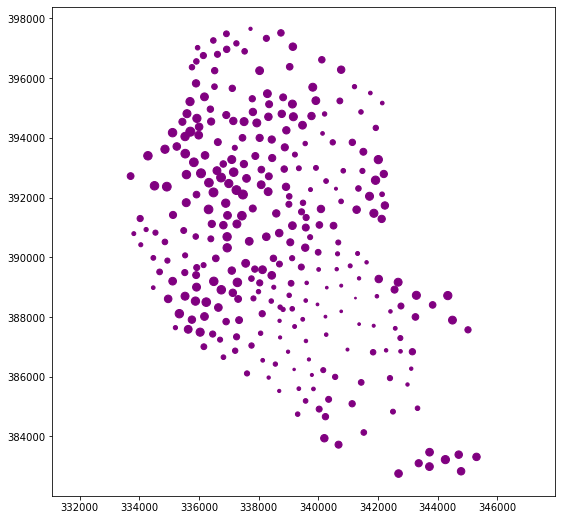

In [12]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the dots, using `imd_score` as a variable to modify
# the size of each dot
ax.scatter(pts[:, 0], pts[:, 1], c='purple', s=imd['imd_score'].values)
# Keep axes proportionate
plt.axis("equal")
# Display
plt.show()

The command `plt.scatter` can also take some of the optional arguments we have learned before, such as color. Have a look at the help of the command ([link](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)) and try modifying some of them to explore changes in the resulting plot.

## `[Extension 2 - Advanced]` Conditional maps

Conditional maps are an attempt to explore multivariate relationships within a choropleth mapping context. In essence, they are figures composed by several choropleths in which the layout of each of them provides information about the subset of the original dataset represented. The idea is that a dataset can be subset based on one or two conditional variables, usually categorical, and only the observations that meet each characteristic are displayed in a given submap. Since they are combinations of choropleths, they build on everything we have learned about their creation. As an example, let us create a conditional map of IMD scores based on the dominating gender and marital status of each area.

From a Python perspective, creating conditional maps is a bit more intricate than standard choropleths because of the conditioning of the data and the arranging of the layout that needs to occur for the final figure to be produced. To be able to use the facetting machinery available in `seaborn`, we need to define a function that generates a choropleth with a given subset of the dataset:

In [13]:
def map_subset(vals, db, color=None, norm=True):
    '''
    Internal function to pass to `FaceGrid` to build a single map
    ...
    
    Arguments
    ---------
    vals     : Series
               Values of the subplot to be mapped
    db       : GeoDataFrame
               Table with geometries
    color    : None
    '''
    ax = plt.gca()
    db.plot(color='0.8', edgecolor='0.8', linewidth=1., ax=ax)
    vari = vals.name
    if norm:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='RdPu', linewidth=0., \
                               vmin=db[vari].min(), vmax=db[vari].max())
    else:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='RdPu', linewidth=0.)
    ax.set_axis_off()
    return None

With this function in hand, we can use it to pass it on to the facetting functionality in `seaborn`, which then takes care of the actual subsetting of the data and proper alignment of the output figures:

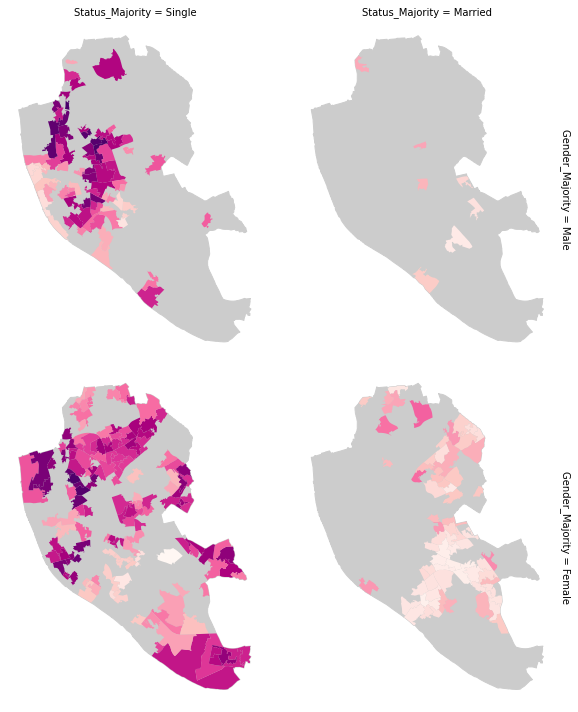

In [15]:
g = sns.FacetGrid(both, row="Gender_Majority", col="Status_Majority", \
                  margin_titles=True, height=5)
g.map(map_subset, "imd_score", db=both)
plt.tight_layout()
plt.show()

The figure contains a few interesting elements:

* The distribution of areas with different characteristics is not random over space but rather follows a specific pattern. For example, the majority of married/female areas are located in the periphery of the city, while most of the single/male LSOAs can be found in the city centre. 
* Since the color scale is common across maps, we can compare the degree of deprivation for different combinations. For example, areas with a more married population display consistently lower levels of deprivation than those where singles prevail.

Although conditional maps are a powerful tool to explore a dataset and generate hypotheses about multivariate relationships, it is important to keep in mind these can only be suggestive. A more formal analysis, such as one based on regression, would be required to establish more robust conclusions, as several confounding factors can be at play.

## `[Extension 3 - Advanced]` MAUP

Although arguably a bit more advanced, if you are curious how the maps that exemplify the [Modifiable Areal Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) (MAUP) in the lecture slides, you can find a notebook illustrating it on this link:

> [https://gist.github.com/darribas/8b5a7b93d4085223f1c5#file-maup-ipynb](https://gist.github.com/darribas/8b5a7b93d4085223f1c5#file-maup-ipynb)

## `[Extension 4]` Maps from lecture slides

* Unique values

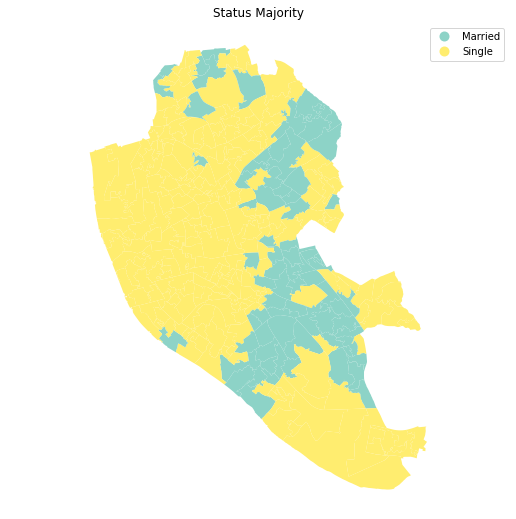

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
both.plot(column='Status_Majority', categorical=True, legend=True, ax=ax, \
          linewidth=0.1, cmap='Set3')
ax.set_title('Status Majority')
ax.set_axis_off()
plt.axis('equal')
#plt.savefig('../lectures/figs/l04_unique_values.png')
plt.show()

* Choropleth classifiers

In [19]:
def plot_scheme(scheme, var, db, figsize=(16, 8), saveto=None):
    '''
    Plot the distribution over value and geographical space of variable `var` using scheme `scheme
    ...
    
    Arguments
    ---------
    scheme   : str
               Name of the classification scheme to use 
    var      : str
               Variable name 
    db       : GeoDataFrame
               Table with input data
    figsize  : Tuple
               [Optional. Default = (16, 8)] Size of the figure to be created.
    saveto   : None/str
               [Optional. Default = None] Path for file to save the plot.
    '''
    from mapclassify import Quantiles, EqualInterval, FisherJenks
    schemes = {'equal_interval': EqualInterval, \
               'quantiles': Quantiles, \
               'fisher_jenks': FisherJenks}
    classi = schemes[scheme](db[var], k=7)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    # KDE
    sns.kdeplot(db[var], shade=True, color='purple', ax=ax1)
    sns.rugplot(db[var], alpha=0.5, color='purple', ax=ax1)
    for cut in classi.bins:
        ax1.axvline(cut, color='blue', linewidth=0.75)
    ax1.set_title('Value distribution')
    # Map
    p = db.plot(column=var, scheme=scheme, alpha=0.75, k=7, \
             cmap=plt.cm.RdPu_r, ax=ax2, linewidth=0.1)
    ax2.axis('equal')
    ax2.set_axis_off()
    ax2.set_title('Geographical distribution')
    f.suptitle(scheme, size=25)
    if saveto:
        plt.savefig(saveto)
    plt.show()

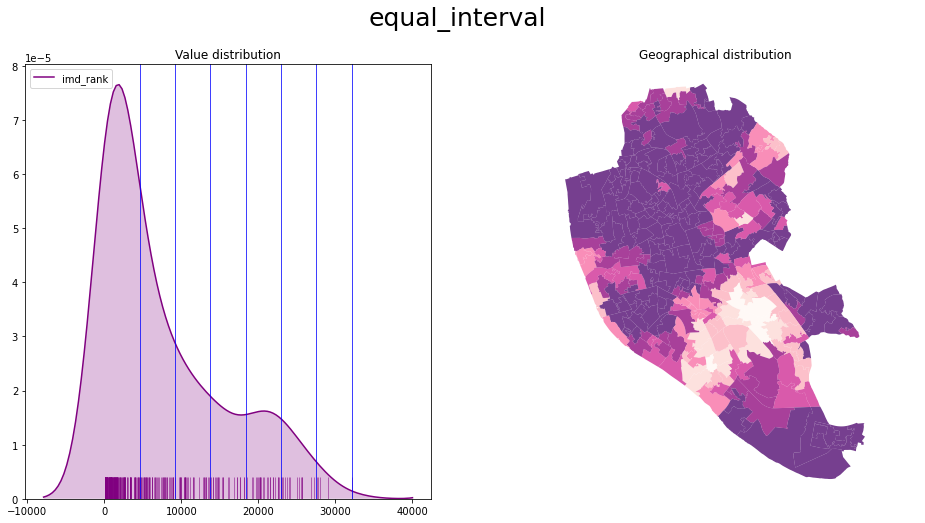

In [20]:
plot_scheme('equal_interval', 'imd_rank', imd)

* Conditional map

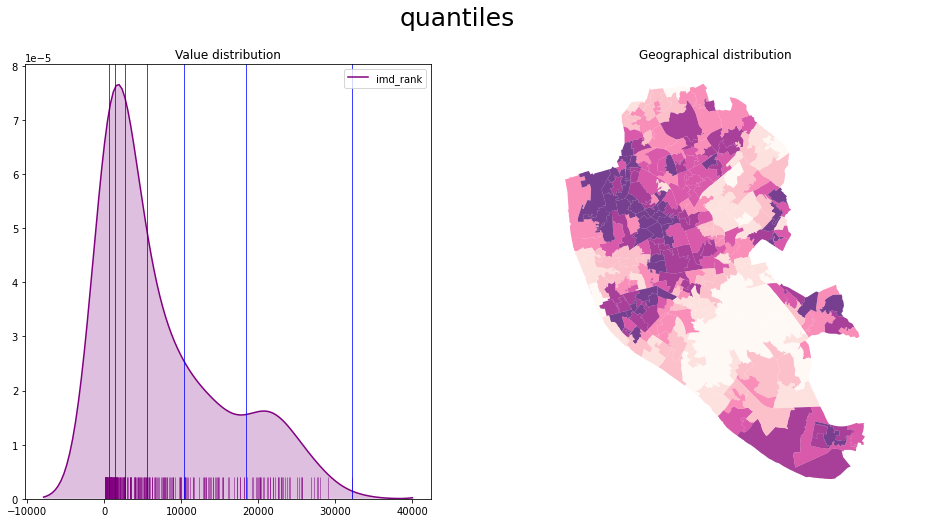

In [21]:
plot_scheme('quantiles', 'imd_rank', imd)

---

<a rel="repo" href="https://github.com/darribas/gds19"><img alt="@darribas/gds19" style="border-width:0" src="../../GitHub-Mark.png" /></a>

This notebook, as well as the entire set of materials, code, and data included
in this course are available as an open Github repository available at: [`https://github.com/darribas/gds19`](https://github.com/darribas/gds19)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'19</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
